## 任务4：构建细粒度高糖预测模型

通过任务3对某一时间段的高糖预测，找到用户出现高糖的所有时间段，再进行每个时刻的细粒度高糖预测，绘制高糖曲线，进而统计一天出现的高糖次数。

### 任务点4.1 构造新的训练集与测试集

从现有训练集中选取所有出现高糖的时间段，将该时间段的观测序列与血糖值序列构成新的训练集；测试集是从原有测试集中找出所有任务3预测为高糖的时间段的数据。可以看出，任务3的结果影响任务4的测试集，因而任务3主要是把出现高糖的时间段尽可能多地筛选出来，更注重召回率。

In [5]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import pandas as pd

def aggregate_data(df):
    # 设定时间窗口为每小时
    df.set_index('datetime', inplace=True)
    
    # 处理重复的时间戳
    df = df[~df.index.duplicated(keep='first')]
    
    # 聚合非营养数据：计算平均值、方差
    agg_functions = {
        'acc_x': ['mean', 'var'],
        'acc_y': ['mean', 'var'],
        'acc_z': ['mean', 'var'],
        'bvp': ['mean', 'var'],
        'eda': ['mean', 'var'],
        'temp': ['mean', 'var'],
        'hr': ['mean', 'var'],
        'ibi': ['mean', 'var'],
        'elevated_hr_past_hour': ['mean', 'var']
    }
    
    # 累积营养数据
    nutrition_columns = ['calorie', 'total_carb', 'sugar', 'protein']
    df[nutrition_columns] = df[nutrition_columns].cumsum()
    
    # 计算 Glucose Value (mg/dL) 每小时内大于等于140的次数
    # 先按小时进行重采样
    hourly_df = df.resample('h').agg({
        'Glucose Value (mg/dL)': lambda x: (x >= 140).sum(),
        **{col: 'sum' for col in nutrition_columns}
    })
    
    # 重命名列
    hourly_df.rename(columns={'Glucose Value (mg/dL)': 'Glucose Condition Count'}, inplace=True)
    
    # 聚合数据
    hourly_data = df.resample('h').agg(agg_functions)
    
    # 添加营养数据
    for col in nutrition_columns:
        hourly_data[col] = hourly_df[col]
    
    # 添加 Glucose Condition Count 列
    hourly_data['Glucose Condition Count'] = hourly_df['Glucose Condition Count']
    
    # 重置索引以便将时间列放回 DataFrame 中
    hourly_data.reset_index(inplace=True)
    
    # 添加小时列
    hourly_data['hour'] = hourly_data['datetime'].dt.hour
    
    # 将多级索引转换为单级索引，并确保列名唯一
    hourly_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in hourly_data.columns.values]
    
    # 添加增量列
    for col, functions in agg_functions.items():
        for func in functions:
            if func == 'mean':
                # 使用多级索引访问特定列
                mean_col_name = f'{col} mean'
                if mean_col_name in hourly_data.columns:
                    hourly_data[f'{col} Increment'] = hourly_data[mean_col_name].diff()
    # 补充开头的缺失值，向上补全
    hourly_data.ffill()
    
    return hourly_data

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 主循环
for file_num in file_nums:
    # 加载处理过的数据
    data_with_nutrition = pd.read_csv(f'processed_data1/nutrition/processed_data_{file_num}_nutrition.csv')
    # 将 datetime 列转换为 datetime 对象
    data_with_nutrition['datetime'] = pd.to_datetime(data_with_nutrition['datetime'])
    
    # 聚合数据
    hourly_aggregated_data = aggregate_data(data_with_nutrition)
    
    # 删除包含 NaN 值的行
    hourly_aggregated_data.dropna(inplace=True)
    
    # 保存处理后的数据
    hourly_aggregated_data.to_csv(f'processed_data1/hourly/processed_data_{file_num}_hourly.csv', index=False)
    
    print(f'processed_data_{file_num}_hourly.csv saved')

processed_data_002_hourly.csv saved
processed_data_003_hourly.csv saved
processed_data_004_hourly.csv saved
processed_data_005_hourly.csv saved
processed_data_006_hourly.csv saved
processed_data_007_hourly.csv saved
processed_data_008_hourly.csv saved
processed_data_009_hourly.csv saved
processed_data_010_hourly.csv saved
processed_data_011_hourly.csv saved
processed_data_012_hourly.csv saved
processed_data_013_hourly.csv saved
processed_data_014_hourly.csv saved
processed_data_015_hourly.csv saved
processed_data_016_hourly.csv saved


C:\Users\aimer\AppData\Local\Temp\ipykernel_86692\4250160747.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[nutrition_columns] = df[nutrition_columns].cumsum()


In [7]:
# 请在下方完成任务
# 从原本的二分类问题变成回归问题，需要预测出具体的高糖次数
# 具体次数在processed_data1/hourly/processed_data_{file_num}_hourly.csv中的Glucose Condition Count列中


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 初始化一个空的DataFrame用于存放所有数据
data_all = pd.DataFrame()

# 对每个文件编号进行处理
for file_num in file_nums:
    # 读取文件
    data = pd.read_csv(f'processed_data1/hourly/processed_data_{file_num}_hourly.csv')
    # 将数据追加到data_all
    data_all = pd.concat([data_all, data], ignore_index=True)

# 选择特征列
selected_features = ['sugar', 'total_carb', 'calorie', 'protein', 'eda mean', 'acc_x mean','hour']
y_column_name = 'Glucose Condition Count'
X = data_all[selected_features]
data_all[y_column_name].fillna(0)
y = data_all[y_column_name]
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化训练集和测试集
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 合并过采样后的特征和目标变量
train_resampled = pd.DataFrame(X_train_scaled, columns=selected_features)
train_resampled[y_column_name] = y_train

# 查看过采样后的前几行数据
print(train_resampled.head())

# 保存处理后的训练集和测试集
train_resampled.to_csv('train_test_data_food/train_resampled.csv', index=False)
pd.DataFrame(X_test_scaled, columns=selected_features).to_csv('train_test_data_food/X_test.csv', index=False)
y_test.to_csv('train_test_data_food/y_test.csv', index=False)

print("Train and test sets have been processed and saved.")

      sugar  total_carb   calorie   protein  eda mean  acc_x mean      hour  \
0 -0.840449   -1.007571 -0.999976 -0.920498  0.284381    0.261893 -0.508527   
1  2.425102    2.490811  2.660813  2.373818 -0.295547   -0.074690 -1.387791   
2 -0.752982   -0.702050 -0.813391 -0.798580  0.456923    1.359779 -0.655071   
3 -0.408833   -0.164873 -0.371195 -0.304758 -0.469279   -0.227058 -1.387791   
4  2.465093    1.953941  1.121864  0.283849 -0.333745   -1.348539  0.956913   

   Glucose Condition Count  
0                      2.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                     10.0  
Train and test sets have been processed and saved.


### 任务点4.2 细粒度高糖预测模型构建与参数调优

可以运用HMM、LSTM等一种时序预测算法，构建一个时间段的高糖时序预测模型，并进行调参；也可以对该时间段内的高糖次数进行回归分析，构建高糖预测回归模型，并进行调参。

Linear Regression: Mean Squared Error=8.2344, R^2 Score=0.0464
Support Vector Regression: Mean Squared Error=9.4818, R^2 Score=-0.0981
Random Forest Regression: Mean Squared Error=7.0494, R^2 Score=0.1836
Gradient Boosting Regression: Mean Squared Error=7.4915, R^2 Score=0.1324
Model Linear Regression has been saved.
Model Support Vector Regression has been saved.
Model Random Forest Regression has been saved.
Model Gradient Boosting Regression has been saved.


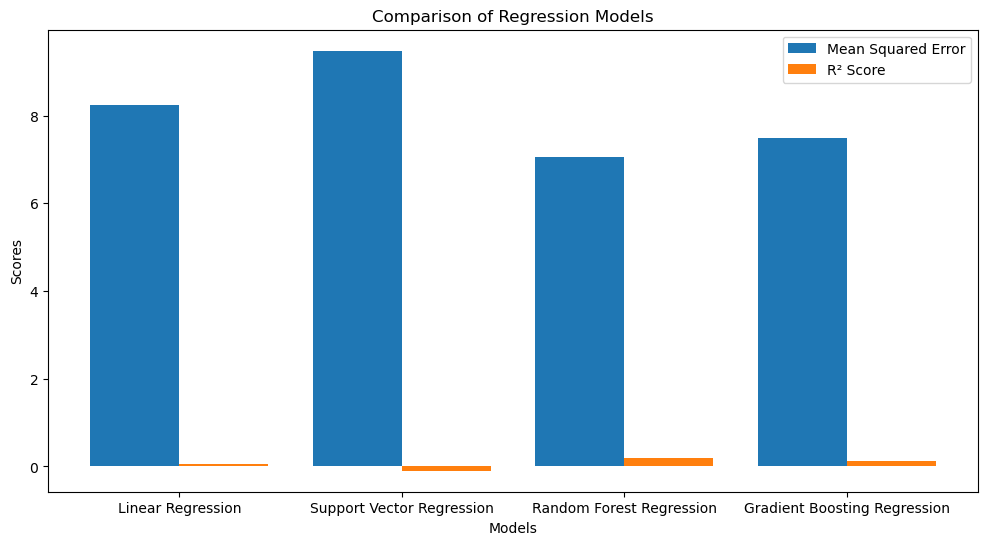

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 初始化一个空的DataFrame用于存放所有数据
data_all = pd.DataFrame()

# 对每个文件编号进行处理
for file_num in file_nums:
    # 读取文件
    data = pd.read_csv(f'processed_data1/hourly/processed_data_{file_num}_hourly.csv')
    # 将数据追加到data_all
    data_all = pd.concat([data_all, data], ignore_index=True)

# 选择特征列
selected_features = ['sugar', 'total_carb', 'calorie', 'protein', 'eda mean', 'acc_x mean', 'hour']
y_column_name = 'Glucose Condition Count'
X = data_all[selected_features]
y = data_all[y_column_name].fillna(0)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化训练集和测试集
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 初始化模型列表
models = [
    ('Linear Regression', LinearRegression()),
    ('Support Vector Regression', SVR(kernel='rbf')),
    ('Random Forest Regression', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting Regression', GradientBoostingRegressor(random_state=42))
]

# 定义参数网格
param_grids = {
    'Support Vector Regression': {'C': [1, 10], 'gamma': ['scale', 'auto']},
    'Random Forest Regression': {'n_estimators': [100, 200], 'max_depth': [None, 10]},
    'Gradient Boosting Regression': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]}
}

# 存储结果
results = []

# 训练并评估每个模型
for name, model in models:
    if name in param_grids:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        model = grid_search.best_estimator_
    else:
        model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, r2))

    print(f"{name}: Mean Squared Error={mse:.4f}, R^2 Score={r2:.4f}")

# 保存模型
for name, model in models:
    joblib.dump(model, f'{name.lower().replace(" ", "_")}_model.pkl')
    print(f"Model {name} has been saved.")

# 可视化结果
names, mse_scores, r2_scores = zip(*results)
indexes = np.arange(len(names))

plt.figure(figsize=(12, 6))
plt.bar(indexes - 0.2, mse_scores, width=0.4, label='Mean Squared Error')
plt.bar(indexes + 0.2, r2_scores, width=0.4, label='R² Score')
plt.xticks(indexes, names)
plt.legend()
plt.title('Comparison of Regression Models')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.show()

### 任务点4.3 模型预测与高糖结果统计

运用所训练的细粒度高糖预测模型预测测试集中每个阶段的高糖变化，并计算测试集中每个用户一天发生高糖的次数，与真实值比较，计算误差RMSE和R2分数；

In [9]:
import pandas as pd

def aggregate_data_daily(df):
    # 设定时间窗口为每天
    df.set_index('datetime', inplace=True)
    
    # 处理重复的时间戳
    df = df[~df.index.duplicated(keep='first')]
    
    # 聚合非营养数据：计算平均值、方差
    agg_functions = {
        'acc_x': ['mean', 'var'],
        'acc_y': ['mean', 'var'],
        'acc_z': ['mean', 'var'],
        'bvp': ['mean', 'var'],
        'eda': ['mean', 'var'],
        'temp': ['mean', 'var'],
        'hr': ['mean', 'var'],
        'ibi': ['mean', 'var'],
        'elevated_hr_past_hour': ['mean', 'var']
    }
    
    # 累积营养数据
    nutrition_columns = ['calorie', 'total_carb', 'sugar', 'protein']
    df[nutrition_columns] = df[nutrition_columns].cumsum()
    
    # 计算 Glucose Value (mg/dL) 每天内大于等于140的次数
    # 先按天进行重采样
    daily_df = df.resample('D').agg({
        'Glucose Value (mg/dL)': lambda x: (x >= 140).sum(),
        **{col: 'sum' for col in nutrition_columns}
    })
    
    # 重命名列
    daily_df.rename(columns={'Glucose Value (mg/dL)': 'Glucose Condition Count'}, inplace=True)
    
    # 聚合数据
    daily_data = df.resample('D').agg(agg_functions)
    
    # 添加营养数据
    for col in nutrition_columns:
        daily_data[col] = daily_df[col]
    
    # 添加 Glucose Condition Count 列
    daily_data['Glucose Condition Count'] = daily_df['Glucose Condition Count']
    
    # 重置索引以便将时间列放回 DataFrame 中
    daily_data.reset_index(inplace=True)
    
    # 添加天数列
    daily_data['day'] = daily_data['datetime'].dt.day
    
    # 将多级索引转换为单级索引，并确保列名唯一
    daily_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in daily_data.columns.values]
    
    # 添加增量列
    for col, functions in agg_functions.items():
        for func in functions:
            if func == 'mean':
                # 使用多级索引访问特定列
                mean_col_name = f'{col} mean'
                if mean_col_name in daily_data.columns:
                    daily_data[f'{col} Increment'] = daily_data[mean_col_name].diff()
    # 补充开头的缺失值，向上补全
    daily_data.ffill(inplace=True)
    
    return daily_data

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 主循环
for file_num in file_nums:
    # 加载处理过的数据
    data_with_nutrition = pd.read_csv(f'processed_data1/nutrition/processed_data_{file_num}_nutrition.csv')
    # 将 datetime 列转换为 datetime 对象
    data_with_nutrition['datetime'] = pd.to_datetime(data_with_nutrition['datetime'])
    
    # 聚合数据
    daily_aggregated_data = aggregate_data_daily(data_with_nutrition)
    
    # 删除包含 NaN 值的行
    daily_aggregated_data.dropna(inplace=True)
    
    # 保存处理后的数据
    daily_aggregated_data.to_csv(f'processed_data1/daily/processed_data_{file_num}_daily.csv', index=False)
    
    print(f'processed_data_{file_num}_daily.csv saved')

processed_data_002_daily.csv saved
processed_data_003_daily.csv saved
processed_data_004_daily.csv saved
processed_data_005_daily.csv saved
processed_data_006_daily.csv saved
processed_data_007_daily.csv saved
processed_data_008_daily.csv saved
processed_data_009_daily.csv saved
processed_data_010_daily.csv saved
processed_data_011_daily.csv saved
processed_data_012_daily.csv saved
processed_data_013_daily.csv saved
processed_data_014_daily.csv saved
processed_data_015_daily.csv saved
processed_data_016_daily.csv saved


C:\Users\aimer\AppData\Local\Temp\ipykernel_86692\1911834497.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[nutrition_columns] = df[nutrition_columns].cumsum()


In [10]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 初始化一个空的DataFrame用于存放所有数据
data_all = pd.DataFrame()

# 对每个文件编号进行处理
for file_num in file_nums:
    # 读取文件
    data = pd.read_csv(f'processed_data1/daily/processed_data_{file_num}_daily.csv')
    # 将数据追加到data_all
    data_all = pd.concat([data_all, data], ignore_index=True)

# 选择特征列
selected_features = ['sugar', 'total_carb', 'calorie', 'protein', 'eda mean', 'acc_x mean']
y_column_name = 'Glucose Condition Count'
X = data_all[selected_features]
data_all[y_column_name].fillna(0)

y = data_all[y_column_name]
print(y)
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train)
# 标准化训练集和测试集
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 合并过采样后的特征和目标变量
train_resampled = pd.DataFrame(X_train_scaled, columns=selected_features)
train_resampled[y_column_name] = y_train

# 查看过采样后的前几行数据
print(train_resampled.head())

# 保存处理后的训练集和测试集
train_resampled.to_csv('train_test_data_day/train_resampled.csv', index=False)
pd.DataFrame(X_test_scaled, columns=selected_features).to_csv('train_test_data_food/X_test.csv', index=False)
y_test.to_csv('train_test_data_day/y_test.csv', index=False)

print("Train and test sets have been processed and saved.")

0       83
1      108
2       70
3        5
4       52
      ... 
116      2
117      8
118     17
119     16
120     27
Name: Glucose Condition Count, Length: 121, dtype: int64
12      9
15      8
115    21
76     59
98     81
       ..
106    85
14      5
92     23
51      0
102    22
Name: Glucose Condition Count, Length: 96, dtype: int64
      sugar  total_carb   calorie   protein  eda mean  acc_x mean  \
0 -0.929193   -0.633335 -0.928076 -1.037653  0.973228   -1.418392   
1 -0.929193   -0.789156 -1.012085 -1.037653 -0.649889   -0.035150   
2 -0.929193   -1.173146 -1.169824 -1.037653 -0.051783    0.986984   
3 -0.068230   -0.357512 -0.660531 -0.763961  0.324275   -0.829472   
4  1.459040    1.585195  1.938092  2.435242 -0.041635   -0.097710   

   Glucose Condition Count  
0                      NaN  
1                    108.0  
2                     70.0  
3                      5.0  
4                      NaN  
Train and test sets have been processed and saved.


In [11]:
# 请在下方完成任务，并保存模型到本地
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# 定义模型
model = RandomForestRegressor()

# 定义参数网格
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # 树的数量
    'max_depth': [10, 20, 30, None],        # 树的最大深度
    'min_samples_split': [2, 5, 10, 20],    # 内部节点再划分所需最小样本数
    'min_samples_leaf': [1, 2, 4, 10]       # 叶子节点所需的最小样本数
}

# 创建网格搜索对象
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 拟合模型
grid_search.fit(X_train_scaled, y_train)

# 获取最佳参数
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# 使用最佳参数训练模型
best_model = grid_search.best_estimator_

# 预测
y_pred = best_model.predict(X_test_scaled)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Mean Squared Error: 557.6585036158277
R^2 Score: -0.014001247395853289
